In [2]:
import json
import numpy as np
from pathlib import Path
import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
with open("plots/style.json") as f:
    mpl.rcParams.update(json.load(f))

In [9]:
problems = ["testem3-composite", "atlas-tilecal", "cms-hgcal", "cms-run3", "cms-hllhc",]
labels = ["Test EM3", "ATLAS tilecal", "CMS HGCAL", "CMS Run 3", "CMS Run 4",]
track_order = ['none', 'reindex-along-step-action', 'init-charge']
optimization = ["none", "async", "plus-init-charge",  "all",]
num_runs = 7

In [10]:
def get_times(results_dir, app):
    result = {p: {} for p in problems}
    for p in problems:
        throughput = []
        num_tracks = []
        for i in range(num_runs):
            with open(results_dir / app / p / f'{i}.json') as f:
                out = json.load(f)
                num_events = out["input"]["primary_options"]["num_events"]
                num_tracks.append(out["input"]["num_track_slots"])
                if app == 'celer-sim':
                    throughput.append(num_events / out["result"]["runner"]["time"]["total"])
                else:
                    throughput.append(num_events / out["result"]["time"]["total"])
        result[p]["num_tracks"] = num_tracks
        result[p]["throughput"] = throughput
    return result

In [11]:
celer_sim = get_times(Path("results/opt-none-scaling/gpu"), "celer-sim")
celer_sim_opt = get_times(Path("results/opt-all-scaling/gpu"), "celer-sim")

results = celer_sim
results_opt = celer_sim_opt

In [12]:
celer_g4 = get_times(Path("results/opt-none-scaling/gpu"), "celer-g4")
celer_g4_opt = get_times(Path("results/opt-all-scaling/gpu"), "celer-g4")

results = celer_g4
results_opt = celer_g4_opt

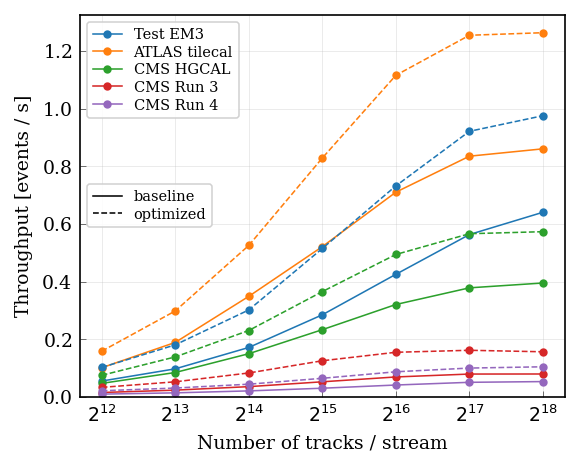

In [16]:
# Set up figure
fig, ax = plt.subplots(1, 1)

colors = plt.cm.tab10.colors[:num_runs]
ms = None
lw = None
problem_handles = []
sorting_handles = []

# Plot results
for i in range(len(problems)):
    k, v = list(results.items())[i]
    exp = np.array([np.log2(t) for t in v["num_tracks"]], dtype=int)
    threads = np.array(v["num_tracks"], dtype = int)
    h = ax.plot(threads, v["throughput"], color=colors[i], marker=".", markersize=ms, linewidth=lw, label=f"{labels[i]}")
    problem_handles.append(h[0])
    
for i in range(len(problems)):
    k, v = list(results_opt.items())[i]
    ax.plot(threads, v["throughput"], color=colors[i], linestyle="--", marker=".", markersize=ms, linewidth=lw)

# Create the problem legend
leg = ax.legend(handles=problem_handles, loc='upper left')

# Create the sorting legend
sorting_handles.append(ax.plot([0], [0], color='k', linestyle='-', linewidth=lw, label="baseline")[0])
sorting_handles.append(ax.plot([0], [0], color='k', linestyle='--', linewidth=lw, label="optimized")[0])
ax.legend(handles=sorting_handles, loc='center left')

# Manually add back the problem legend
ax.add_artist(leg)

thread_labels = [fr"$2^{{{x}}}$" for x in exp]

ax.grid(True, which='major', alpha=0.6)
ax.set_xscale('log')
ax.set_xticklabels([], minor=True)
ax.set_xticks(threads, thread_labels)
ax.set_xlabel("Number of tracks / stream")
ax.set_ylabel("Throughput [events / s]")
ax.set_ylim((0, ax.get_ylim()[1]))
ax.xaxis.minorticks_off()
plt.show()
fig.savefig('gpu-threads-sim.pdf')

/var/folders/n9/mqnx20b929z469f6p3fbq7c40000gn/T/ipykernel_92147/1337998661.py:34: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  leg = ax1.legend(handles=problem_handles, loc=(0.015, 0.685),)


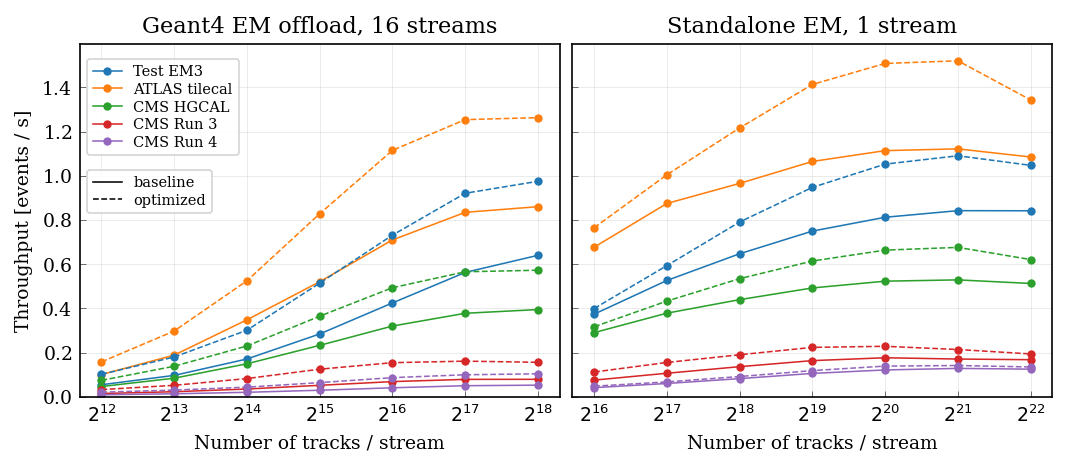

In [42]:
# Set up figure
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7,3))
colors = plt.cm.tab10.colors[:num_runs]
ms = None
lw = None
problem_handles = []
sorting_handles = []

# Plot celer-g4 results
for i in range(len(problems)):
    k, v = list(celer_g4.items())[i]
    exp_g4 = np.array([np.log2(t) for t in v["num_tracks"]], dtype=int)
    threads_g4 = np.array(v["num_tracks"], dtype = int)
    h = ax1.plot(threads_g4, v["throughput"], color=colors[i], linestyle="-", marker=".", markersize=ms, linewidth=lw, label=f"{labels[i]}")
    problem_handles.append(h[0])
    
for i in range(len(problems)):
    k, v = list(celer_g4_opt.items())[i]
    ax1.plot(threads_g4, v["throughput"], color=colors[i], linestyle="--", marker=".", markersize=ms, linewidth=lw)

# Plot celer-sim results
for i in range(len(problems)):
    k, v = list(celer_sim.items())[i]
    exp_sim = np.array([np.log2(t) for t in v["num_tracks"]], dtype=int)
    threads_sim = np.array(v["num_tracks"], dtype = int)
    h = ax2.plot(threads_sim, v["throughput"], color=colors[i], linestyle="-", marker=".", markersize=ms, linewidth=lw)
    problem_handles.append(h[0])
    
for i in range(len(problems)):
    k, v = list(celer_sim_opt.items())[i]
    ax2.plot(threads_sim, v["throughput"], color=colors[i], linestyle="--", marker=".", markersize=ms, linewidth=lw)

# Create the problem legend
leg = ax1.legend(handles=problem_handles, loc=(0.015, 0.685),)

# Create the sorting legend
sorting_handles.append(ax1.plot([0], [0], color='k', linestyle='-', linewidth=lw, label="baseline")[0])
sorting_handles.append(ax1.plot([0], [0], color='k', linestyle='--', linewidth=lw, label="optimized")[0])
ax1.legend(handles=sorting_handles, loc=(0.015, 0.52))

# Manually add back the problem legend
ax1.add_artist(leg)

thread_labels_g4 = [fr"$2^{{{x}}}$" for x in exp_g4]
thread_labels_sim = [fr"$2^{{{x}}}$" for x in exp_sim]

for ax in (ax1, ax2):
    ax.grid(True, which='major', alpha=0.6)
    ax.set_xscale('log')
    ax.set_xticklabels([], minor=True)
    ax.set_xlabel("Number of tracks / stream")
    ax.set_ylim((0, ax.get_ylim()[1]))
    ax.tick_params(direction="in")
    ax.xaxis.minorticks_off()

ax1.set_title("Geant4 EM offload, 16 streams")
ax2.set_title("Standalone EM, 1 stream")
ax1.set_xticks(threads_g4, thread_labels_g4)
ax2.set_xticks(threads_sim, thread_labels_sim)
ax1.set_ylabel("Throughput [events / s]")
plt.show()
fig.savefig('gpu-thread-scaling.pdf', bbox_inches='tight')

In [23]:
def get_bars(arch, app):
    opt = optimization
    if arch == 'cpu':
        opt = ['g4'] + opt
    result = {o: {} for o in opt}
    for o in opt:
        throughput = []
        num_tracks = []
        for p in problems:
            with open(Path(f'results/opt-{o}') / arch / app / p / '0.json') as f:
                out = json.load(f)
                num_events = out["input"]["primary_options"]["num_events"]
                num_tracks.append(out["input"]["num_track_slots"])
                if app == 'celer-sim':
                    throughput.append(num_events / out["result"]["runner"]["time"]["total"])
                else:
                    throughput.append(num_events / out["result"]["time"]["total"])
        result[o]["num_tracks"] = num_tracks
        result[o]["throughput"] = throughput
    return result

In [24]:
cpu_g4 = get_bars('cpu', 'celer-g4')
gpu_g4 = get_bars('gpu', 'celer-g4')

result_cpu = cpu_g4
result_gpu = gpu_g4

In [27]:
opt = optimization

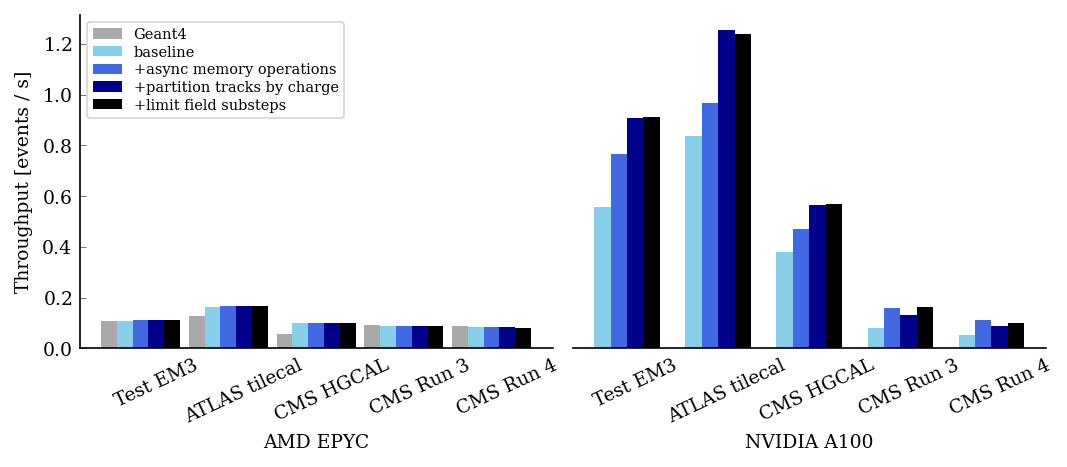

In [43]:
# Set up figure
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(7, 3))

opt_labels = {'g4': 'Geant4', 'none': 'baseline', 'async': '+async memory operations', 'plus-init-charge': '+partition tracks by charge', 'all': '+limit field substeps',}
colors = ['skyblue', 'royalblue', 'darkblue', 'black']
x = np.arange(len(labels))
width = 0.18

for o, w, c in zip(['g4'] + opt, [x - 3 * width, x - 2 * width, x - width, x, x + width, x + 2 * width], ['darkgrey'] + colors):
    ax1.bar(w, result_cpu[o]['throughput'], width, color=c, label=opt_labels[o])

for o, w, c in zip(opt, [x - 2 * width, x - width, x, x + width, x + 2 * width], colors):
    ax2.bar(w, result_gpu[o]['throughput'], width, color=c, label=opt_labels[o])

# Common settings for both axes
for ax in (ax1, ax2):
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=25)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', bottom=False)

# Axis-specific settings
ax1.set_xlabel('AMD EPYC')
ax1.set_ylabel('Throughput [events / s]')
ax2.set_xlabel('NVIDIA A100')
ax1.spines['right'].set_visible(False)
ax1.tick_params(direction="in")

ax2.set_yticks([])
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Match y-axis limits
ax1.set_ylim(ax2.get_ylim())

#ax1.set_yticks([])
# plt.subplots_adjust(wspace=0)

# Add a legend
ax1.legend(loc='upper left')
fig.savefig('throughput-g4.pdf')

In [379]:
result_cpu

{'g4': {'num_tracks': [4096, 4096, 4096, 4096, 4096],
  'throughput': [0.10781280112119564,
   0.12780554858356807,
   0.05523407359712326,
   0.09278567006307352,
   0.08767804709682793]},
 'none': {'num_tracks': [4096, 4096, 4096, 4096, 4096],
  'throughput': [0.10855610826878029,
   0.16436960741621323,
   0.09809178256706697,
   0.08945351976406092,
   0.08504827782883326]},
 'async': {'num_tracks': [4096, 4096, 4096, 4096, 4096],
  'throughput': [0.10984178102432776,
   0.1647012832512622,
   0.09815437455201677,
   0.08899693559927052,
   0.08407239979840352]},
 'plus-init-charge': {'num_tracks': [4096, 4096, 4096, 4096, 4096],
  'throughput': [0.11151247085402384,
   0.1652954192380534,
   0.09875453675456367,
   0.08957430436463529,
   0.08281771674730905]},
 'all': {'num_tracks': [4096, 4096, 4096, 4096, 4096],
  'throughput': [0.11079323382769206,
   0.16473517341289473,
   0.09769700529620563,
   0.08719628990125335,
   0.08077102932529222]}}

In [390]:
result_gpu['all']['throughput'] / np.array(result_gpu['none']['throughput'])

array([1.63343908, 1.48320236, 1.49905341, 2.04189846, 1.98296094])

In [391]:
result_gpu['async']['throughput'] / np.array(result_gpu['none']['throughput'])

array([1.37447904, 1.16025306, 1.23960815, 1.99026586, 2.18622883])

In [392]:
result_gpu['plus-init-charge']['throughput'] / np.array(result_gpu['async']['throughput'])

array([1.18387837, 1.29354533, 1.20673266, 0.82177452, 0.78766318])

In [393]:
result_gpu['all']['throughput'] / np.array(result_gpu['plus-init-charge']['throughput'])

array([1.00382437, 0.9882482 , 1.00212435, 1.24844777, 1.15153727])